#### Building a K-NN Classifier for the images
As a preliminary model to build a baseline for a classifier that utilizes a simple algorithm, I will utlize the K-NN algorithm.


In [1]:
# import the necessary packages
from imutils import paths
import numpy as np
import imutils
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt

# import sklearn packages
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import (KNeighborsClassifier,
                               NeighborhoodComponentsAnalysis)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv("data/meta/working_df_subset.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10100 entries, 0 to 10099
Data columns (total 6 columns):
food_class        10100 non-null object
label             10100 non-null object
label_id          10100 non-null int64
photo_id          10100 non-null object
path              10100 non-null object
training_image    10100 non-null int64
dtypes: int64(2), object(4)
memory usage: 473.5+ KB


In [3]:
def image_to_feature_vector(image, size=(32,32)):
    #resize an image to a fixed size, then flatten image
    # int a list of raw pixel intesities
    # this is necessary to ensure that the images are a standard data
    # format for our classifier
    return cv2.resize(image, size).flatten()

In [4]:
def extract_color_histogram(image, bins=(8,8,8)):
    # extract a 3D color histogram from the HSV color space
    # using the supplied number of 'bins' per channel
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hist = cv2.calcHist([hsv], [0,1,2], None, bins, 
           [0,180,0,256,0,256])
    
    # handle normalizing the histogram if we are using OPenCV 2.4.X
    if imutils.is_cv2():
        hist = cv2.normalize(hist)
        
    # otherwise, perform 'in place' normalization in OpenCV3
    else:
        cv2.normalize(hist,hist)
        
    # return the flattened histogram as the feature vector
    return hist.flatten()

In [15]:
# initiate pixel intensity, features, and labels matrixes
# this will hold the images in their raw pixel representations
raw_images = []
# this will hold the color histograms per image
features = []
image_paths = data['path'].tolist()
labels = data['label_id'].tolist()

# for each image, extract features and add aggragate them into an array
for (i, image_path) in enumerate(image_paths):
    image = cv2.imread(image_path + ".jpg")
    pixels = image_to_feature_vector(image)
    hist = extract_color_histogram(image)
    
    # update the raw images, features, and label matricies,
    # respectively
    raw_images.append(pixels)
    features.append(hist)
    # show an update every 1,000 images
    if i > 0 and i % 100 == 0:
        print("[INFO] processed {}/{}".format(i, len(image_paths)))
    
print("[INFO] completed processing images.")
raw_images = np.array(raw_images)
features = np.array(features)
labels = np.array(labels)

[INFO] processed 100/10100
[INFO] processed 200/10100
[INFO] processed 300/10100
[INFO] processed 400/10100
[INFO] processed 500/10100
[INFO] processed 600/10100
[INFO] processed 700/10100
[INFO] processed 800/10100
[INFO] processed 900/10100
[INFO] processed 1000/10100
[INFO] processed 1100/10100
[INFO] processed 1200/10100
[INFO] processed 1300/10100
[INFO] processed 1400/10100
[INFO] processed 1500/10100
[INFO] processed 1600/10100
[INFO] processed 1700/10100
[INFO] processed 1800/10100
[INFO] processed 1900/10100
[INFO] processed 2000/10100
[INFO] processed 2100/10100
[INFO] processed 2200/10100
[INFO] processed 2300/10100
[INFO] processed 2400/10100
[INFO] processed 2500/10100
[INFO] processed 2600/10100
[INFO] processed 2700/10100
[INFO] processed 2800/10100
[INFO] processed 2900/10100
[INFO] processed 3000/10100
[INFO] processed 3100/10100
[INFO] processed 3200/10100
[INFO] processed 3300/10100
[INFO] processed 3400/10100
[INFO] processed 3500/10100
[INFO] processed 3600/10100
[

In [16]:
print("[INFO] pixels matrix: {:.2f}MB".format(
    raw_images.nbytes / (1024 * 1000.0)))
print("[INFO] features matrix: {:.2f}MB".format(
    raw_images.nbytes / (1024 * 1000.0)))

[INFO] pixels matrix: 30.30MB
[INFO] features matrix: 30.30MB


In [17]:
np.savetxt('pixels.csv', raw_images, delimiter=',')
np.savetxt('features.csv',features,delimiter=',')

In [18]:
print(labels)

[  0   0   0 ... 100 100 100]


In [19]:
# partition the data into training and testing splits, using 75%
# of the data for training and the remaining 25% for testing
(train_RI, test_RI, train_RL, test_RL) = train_test_split(
    raw_images, labels, test_size=0.2, random_state=42)
(train_feat, test_feat, train_labels, test_labels) = train_test_split(
    features, labels, test_size=0.2, random_state=42)

In [20]:
# train and evaluate a k-NN classifer on the raw pixel intensities
print("[INFO] evaluating raw pixel accuracy...")
model = KNeighborsClassifier(n_neighbors=7, n_jobs=-1)
model.fit(train_RI, train_RL)
acc = model.score(test_RI, test_RL)
print("[INFO] raw pixel accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating raw pixel accuracy...
[INFO] raw pixel accuracy: 2.23%


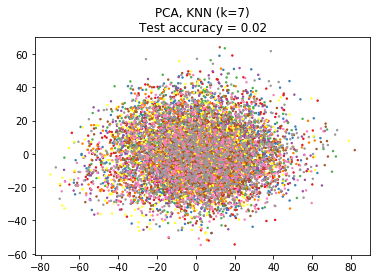

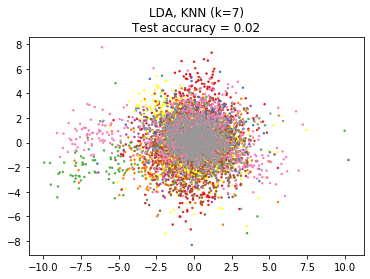

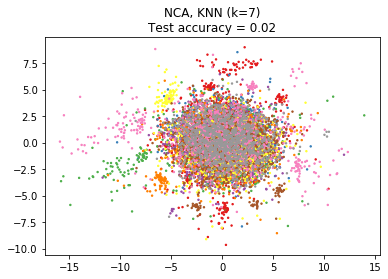

In [22]:
dim = len(train_RI[0])
n_classes = len(np.unique(train_RL))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(),
                    PCA(n_components=2, random_state=42))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(),
                    LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components=2,
                                                   random_state=42))

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=7)

# Make a list of the methods to be compared
dim_reduction_methods = [('PCA', pca), ('LDA', lda), ('NCA', nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # plt.subplot(1, 3, i + 1, aspect=1)

    # Fit the method's model
    model.fit(train_RI, train_RL)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(train_RI), train_RL)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(test_RI), test_RL)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(raw_images)

    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, s=2, cmap='Set1')
    plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format(name,
                                                              7,
                                                              acc_knn))
plt.show()

In [23]:
# train and evaluate a k-NN classifer on the histogram
# representations
print("[INFO] evaluating histogram accuracy...")
model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
model.fit(train_feat, train_labels)
acc = model.score(test_feat, test_labels)
print("[INFO] histogram accuracy: {:.2f}%".format(acc * 100))

[INFO] evaluating histogram accuracy...
[INFO] histogram accuracy: 3.76%


As expected, the classifier is having a hard time identifying the images. This is most likely happening because the data has too many features and classes for the algorithm to handle correctly.

Next we will try a logistic regressor to build another baseline. Following that we will implement a deep learning method.

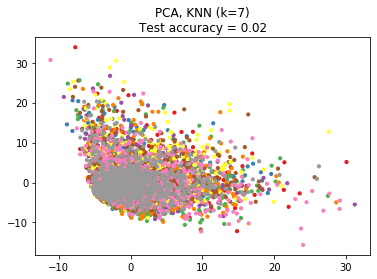

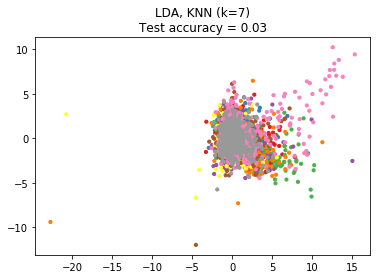

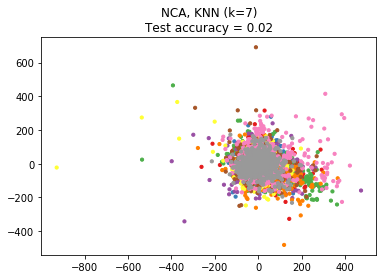

In [25]:
dim = len(train_RI[0])
n_classes = len(np.unique(train_labels))

# Reduce dimension to 2 with PCA
pca = make_pipeline(StandardScaler(),
                    PCA(n_components=2, random_state=42))

# Reduce dimension to 2 with LinearDiscriminantAnalysis
lda = make_pipeline(StandardScaler(),
                    LinearDiscriminantAnalysis(n_components=2))

# Reduce dimension to 2 with NeighborhoodComponentAnalysis
nca = make_pipeline(StandardScaler(),
                    NeighborhoodComponentsAnalysis(n_components=2,
                                                   random_state=42))

# Use a nearest neighbor classifier to evaluate the methods
knn = KNeighborsClassifier(n_neighbors=7)

# Make a list of the methods to be compared
dim_reduction_methods = [('PCA', pca), ('LDA', lda), ('NCA', nca)]

# plt.figure()
for i, (name, model) in enumerate(dim_reduction_methods):
    plt.figure()
    # Fit the method's model
    model.fit(train_feat, train_labels)

    # Fit a nearest neighbor classifier on the embedded training set
    knn.fit(model.transform(train_feat), train_labels)

    # Compute the nearest neighbor accuracy on the embedded test set
    acc_knn = knn.score(model.transform(test_feat), test_labels)

    # Embed the data set in 2 dimensions using the fitted model
    X_embedded = model.transform(features)

    cmap = plt.cm.Spectral
    norm = plt.Normalize()
    
    # Plot the projected points and show the evaluation score
    plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=labels, s=10, cmap='Set1')
    plt.title("{}, KNN (k={})\nTest accuracy = {:.2f}".format(name,
                                                              7,
                                                              acc_knn))
plt.show()